In [1]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
from torch import optim
from torch.autograd import Variable
import numpy as np
import os
import math
from torch import nn
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import matplotlib.pyplot as plt  
import itertools
import random
import h5py
import time
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

## DataLoader

In [2]:
### handle the dataset
class TorchDataset(Dataset):
    def __init__(self, trs_file, label_file, trace_num, trace_offset, trace_length):
        self.trs_file = trs_file
        self.label_file = label_file
        self.trace_num = trace_num
        self.trace_offset = trace_offset
        self.trace_length = trace_length
        self.ToTensor = transforms.ToTensor()
    def __getitem__(self, i):
        index = i % self.trace_num
        trace = self.trs_file[index,:]
        label = self.label_file[index]
        trace = trace[self.trace_offset:self.trace_offset+self.trace_length]
        trace = np.reshape(trace,(1,-1))
        trace = self.ToTensor(trace)
        trace = np.reshape(trace, (1,-1))
        label = torch.tensor(label, dtype=torch.long) 
        return trace.float(), label
    def __len__(self):
        return self.trace_num
    
### data loader for training
def load_training(batch_size, kwargs):
    data = TorchDataset(**kwargs)
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=1, pin_memory=True)
    return train_loader

### data loader for testing
def load_testing(batch_size, kwargs):
    data = TorchDataset(**kwargs)
    test_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=1, pin_memory=True)
    return test_loader

## Arrays and Functions

In [3]:
Sbox = [99, 124, 119, 123, 242, 107, 111, 197, 48, 1, 103, 43, 254, 215, 171, 118, 202, 130, 201, 125, 250, 89, 71,
        240, 173, 212, 162, 175, 156, 164, 114, 192, 183, 253, 147, 38, 54, 63, 247, 204, 52, 165, 229, 241, 113, 216,
        49, 21, 4, 199, 35, 195, 24, 150, 5, 154, 7, 18, 128, 226, 235, 39, 178, 117, 9, 131, 44, 26, 27, 110, 90, 160,
        82, 59, 214, 179, 41, 227, 47, 132, 83, 209, 0, 237, 32, 252, 177, 91, 106, 203, 190, 57, 74, 76, 88, 207, 208,
        239, 170, 251, 67, 77, 51, 133, 69, 249, 2, 127, 80, 60, 159, 168, 81, 163, 64, 143, 146, 157, 56, 245, 188,
        182, 218, 33, 16, 255, 243, 210, 205, 12, 19, 236, 95, 151, 68, 23, 196, 167, 126, 61, 100, 93, 25, 115, 96,
        129, 79, 220, 34, 42, 144, 136, 70, 238, 184, 20, 222, 94, 11, 219, 224, 50, 58, 10, 73, 6, 36, 92, 194, 211,
        172, 98, 145, 149, 228, 121, 231, 200, 55, 109, 141, 213, 78, 169, 108, 86, 244, 234, 101, 122, 174, 8, 186,
        120, 37, 46, 28, 166, 180, 198, 232, 221, 116, 31, 75, 189, 139, 138, 112, 62, 181, 102, 72, 3, 246, 14, 97,
        53, 87, 185, 134, 193, 29, 158, 225, 248, 152, 17, 105, 217, 142, 148, 155, 30, 135, 233, 206, 85, 40, 223, 140,
        161, 137, 13, 191, 230, 66, 104, 65, 153, 45, 15, 176, 84, 187, 22]

HW_byte = [0, 1, 1, 2, 1, 2, 2, 3, 1, 2, 2, 3, 2, 3, 3, 4, 1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 1, 2, 2,
            3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 1, 2, 2, 3, 2, 3,
            3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 2, 3, 3, 4, 3, 4, 4, 5, 3,
            4, 4, 5, 4, 5, 5, 6, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4,
            3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5,
            6, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 3, 4,
            4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 4, 5, 5, 6, 5,
            6, 6, 7, 5, 6, 6, 7, 6, 7, 7, 8]

### To train a network 
def train(epoch, model, scheduler):
    """
    - epoch : the current epoch
    - model : the current model 
    - learning_rate : learning rate   
    """
    # enter training mode 
    model.train() 
    # Instantiate the Iterator
    iter_ = iter(train_loader)
    # get the number of batches
    num_iter = len(train_loader)
    clf_criterion = nn.CrossEntropyLoss()
    # train on each batch of data
    for i in range(1, num_iter+1):
        data, label = iter_.next()
        if cuda:
            data, label = data.cuda(), label.cuda()
        data, label = Variable(data), Variable(label)
        optimizer.zero_grad()
        prediction = model(data)
        loss = clf_criterion(prediction, label)
        preds = prediction.data.max(1, keepdim=True)[1]
        correct_batch = preds.eq(label.data.view_as(preds)).sum()
        # optimzie the cross-entropy loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        if i % log_interval == 0:
            print('Train Epoch {}: [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAcc: {:.6f}%'.format(
                epoch, i * len(data), len(train_loader) * batch_size,
                100. * i / len(train_loader), loss.data, float(correct_batch) * 100. /batch_size))
    
### validation 
def validation(model):
    # enter evaluation mode
    model.eval()
    valid_loss = 0
    # the number of correct prediction
    correct_valid = 0
    clf_criterion = nn.CrossEntropyLoss()
    for data, label in valid_loader:
        if cuda:
            data, label = data.cuda(), label.cuda()
        data, label = Variable(data), Variable(label)
        valid_preds = model(data)
        # sum up batch loss
        valid_loss += clf_criterion(valid_preds, label) 
        # get the index of the max probability
        pred = valid_preds.data.max(1)[1] 
        # get the number of correct prediction
        correct_valid += pred.eq(label.data.view_as(pred)).cpu().sum()
    valid_loss /= len(valid_loader)
    valid_acc = 100. * correct_valid / len(valid_loader.dataset)
    print('Validation: loss: {:.4f}, accuracy: {}/{} ({:.6f}%)'.format(
        valid_loss.data, correct_valid, len(valid_loader.dataset),
        valid_acc))
    return valid_loss, valid_acc

### test/attack
def test(model, disp_GE=True, model_flag='pretrained'):
    """
    - model : the current model 
    - disp_GE : whether to attack/calculate guessing entropy (GE)
    - model_flag : a string for naming GE result
    """
    # enter evaluation mode
    model.eval()
    test_loss = 0
    # the number of correct prediction
    correct = 0
    epoch = 0
    clf_criterion = nn.CrossEntropyLoss()
    
    # Initialize the prediction and label lists(tensors)
    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
    test_preds_all = torch.zeros((test_num, class_num), dtype=torch.float, device='cpu')
    for data, label in test_loader:
        if cuda:
            data, label = data.cuda(), label.cuda()
        data, label = Variable(data), Variable(label)
        test_preds = model(data)
        # sum up batch loss
        test_loss += clf_criterion(test_preds, label) 
        # get the index of the max probability
        pred = test_preds.data.max(1)[1]
        # get the softmax results for attack/showing guessing entropy
        softmax = nn.Softmax(dim=1)
        test_preds_all[epoch*batch_size:(epoch+1)*batch_size, :] =softmax(test_preds)
        # get the predictions (predlist) and real labels (lbllist) for showing confusion matrix
        predlist=torch.cat([predlist,pred.view(-1).cpu()])
        lbllist=torch.cat([lbllist,label.view(-1).cpu()])
        # get the number of correct prediction
        correct += pred.eq(label.data.view_as(pred)).cpu().sum()
        epoch += 1
    test_loss /= len(test_loader)
    print('test loss: {:.4f}, test accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss.data, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    # get the confusion matrix
    confusion_mat = confusion_matrix(lbllist.numpy(), predlist.numpy())
    # show the confusion matrix
    # plot_sonfusion_matrix(confusion_mat, classes = range(class_num))
    # show the guessing entropy and success rate
    if disp_GE:
        plot_guessing_entropy(test_preds_all.numpy(), real_key, model_flag)


### show the guessing entropy and success rate
def plot_guessing_entropy(preds, real_key, model_flag):
    """
    - preds : the probability for each class (n*256 for a byte, n*9 for Hamming weight)
    - real_key : the key of the target device
    - model_flag : a string for naming GE result
    """
    # GE/SR is averaged over 100 attacks 
    num_averaged = 100
    # max trace num for attack
    trace_num_max = 500
    # the step trace num increases
    step = 1
    if trace_num_max > 400 and trace_num_max < 1000:
        step = 2
    if trace_num_max >= 1000 and trace_num_max < 5000:
        step = 4
    if trace_num_max >= 5000 and trace_num_max < 10000:
        step = 5
    guessing_entropy = np.zeros((num_averaged, int(trace_num_max/step)))

    # attack multiples times for average
    for time in range(num_averaged):
        # select the attack traces randomly
        random_index = list(range(plaintext.shape[0]))
        random.shuffle(random_index)
        random_index = random_index[0:trace_num_max]
        # initialize score matrix
        score_mat = np.zeros((trace_num_max, 256))
        for key_guess in range(0, 256):
            for i in range(0, trace_num_max):
                initialState = plaintext[random_index[i]] ^ key_guess
                sout = Sbox[initialState]
                if labeling_method == 'identity':
                    label = sout
                elif labeling_method == 'hw':
                    label = HW_byte[sout]
                score_mat[i, key_guess] = preds[random_index[i], label]
        score_mat = np.log(score_mat + 1e-40)
        for i in range(0, int(trace_num_max/step)):
            log_likelihood = np.sum(score_mat[0:i*step+1,:], axis=0)
            ranked = np.argsort(log_likelihood)[::-1]
            guessing_entropy[time,i] =  list(ranked).index(real_key)
    guessing_entropy = np.mean(guessing_entropy,axis=0)
    plt.figure(figsize=(20,10))
    plt.subplot(1, 1, 1)
    plt.grid(True)
    x = range(0, trace_num_max, step)
    p1, = plt.plot(x, guessing_entropy[0:int(trace_num_max/step)],color='red')
    plt.xlabel('Number of trace')
    plt.ylabel('Guessing entropy')
    #np.save('./results/bilinear_entropy_'+ labeling_method + '_ascad_fixed_' + model_flag + '_'+ desync, guessing_entropy)
    plt.show()

### show the confusion matrix
def plot_sonfusion_matrix(cm, classes, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.ylim((len(classes)-0.5, -0.5))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predict label')
    plt.show()
    
# correlation of two matrix
def Matrix_Cor(X, Y):
    if X.shape[0] != Y.shape[0]:
        print("X and Y have wrong shape")
        return
#     print(
#         "Start calculating the correlation between power trace and intermedia data_file_path"
#     )
    N, col_X = X.shape
    col_Y = Y.shape[1]

    Sum_of_X = X.sum(axis=0)
    # print(Sum_of_X.shape)
    Sum_of_Y = Y.sum(axis=0)
    # print(Sum_of_Y.shape)
    Sum_of_X2 = (X * X).sum(axis=0)
    # print(Sum_of_X2.shape)
    Sum_of_Y2 = (Y * Y).sum(axis=0)
    # print(Sum_of_Y2.shape)
    Sum_of_XY = (X.T).dot(Y)
    # print(Sum_of_XY.shape)

    r = N * Sum_of_XY - Sum_of_X.reshape(
        (col_X, 1)).dot(Sum_of_Y.reshape(1, col_Y))
    r = r / np.sqrt(
        (N * Sum_of_X2 - Sum_of_X * Sum_of_X).reshape(col_X, 1).dot(
            (N * Sum_of_Y2 - Sum_of_Y * Sum_of_Y).reshape(1, col_Y)))
#     print(
#         "Finished.The correlation matrix is retured.\nPlease run CPA(result=result) to see the key rank."
#     )
    return r.T

## Setups

In [4]:
real_key = 34 # key value
labeling_method = 'identity' # labeling of trace
preprocess = 'feature_standardization' # preprocess method
batch_size = 600
total_epoch = 50
lr = 0.005 # learning rate
log_interval = 100 # epoch interval to log training information
train_num = 195000
valid_num = 5000
test_num = 100000
trace_offset = 0
trace_length = 1400
file_path = './Data/ASCAD_var/'
desync = 'desync_0'
no_cuda =False
cuda = not no_cuda and torch.cuda.is_available()
seed = 8
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)
if labeling_method == 'identity':
    class_num = 256
elif labeling_method == 'hw':
    class_num = 9

# to load traces and labels
X_train = np.load(file_path + 'X_train.npy')
Y_train = np.load(file_path + 'Y_train.npy')
X_attack = np.load(file_path + 'X_attack.npy')
Y_attack = np.load(file_path + 'Y_attack.npy')

# to load plaintexts
plaintext = np.load(file_path + 'plaintexts_attack.npy')
plaintext = plaintext[0:test_num,2]

# preprocess of traces

if preprocess == 'feature_standardization':
    scaler = preprocessing.StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_attack = scaler.transform(X_attack)
elif preprocess == 'feature_scaling':
    scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
    X_train = scaler.fit_transform(X_train)
    X_attack = scaler.transform(X_attack)
elif preprocess == 'horizontal_standardization':
    mn = np.repeat(np.mean(X_train, axis=1, keepdims=True), X_train.shape[1], axis=1)
    std = np.repeat(np.std(X_train, axis=1, keepdims=True), X_train.shape[1], axis=1)
    X_train = (X_train - mn)/std

    mn = np.repeat(np.mean(X_attack, axis=1, keepdims=True), X_attack.shape[1], axis=1)
    std = np.repeat(np.std(X_attack, axis=1, keepdims=True), X_attack.shape[1], axis=1)
    X_attack = (X_attack - mn)/std
elif preprocess == 'horizontal_scaling':
    scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(X_train.T)
    X_train = scaler.transform(X_train.T).T

    scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(X_attack.T)
    X_attack = scaler.transform(X_attack.T).T


# parameters of data loader
kwargs_train = {
        'trs_file': X_train[0:train_num,:],
        'label_file': Y_train[0:train_num],
        'trace_num':train_num,
        'trace_offset':trace_offset,
        'trace_length':trace_length,
}
kwargs_valid = {
        'trs_file': X_train[train_num:train_num+valid_num,:],
        'label_file': Y_train[train_num:train_num+valid_num],
        'trace_num':valid_num,
        'trace_offset':trace_offset,
        'trace_length':trace_length,
}
kwargs_test = {
        'trs_file': X_attack[0:test_num,:],
        'label_file': Y_attack[0:test_num],
        'trace_num':test_num,
        'trace_offset':trace_offset,
        'trace_length':trace_length,
}

train_loader = load_training(batch_size, kwargs_train)
valid_loader = load_training(batch_size, kwargs_valid)
test_loader = load_testing(batch_size, kwargs_test)
print('Load data complete!')

Load data complete!


## Models

In [5]:
### the pre-trained model
class Net(nn.Module):
    def __init__(self, num_classes=class_num):
        super(Net, self).__init__()
        # the encoder part
        self.features = nn.Sequential(
            nn.Conv1d(1, 2, kernel_size=1),
            nn.SELU(),
            nn.BatchNorm1d(2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Flatten()
        )
        # the fully-connected layer 1
        self.classifier_1 = nn.Sequential(
            nn.Linear(1400, 20),
            nn.SELU(),
        )
        # the fully-connected layer 2
        self.classifier_2 = nn.Sequential(
            nn.Linear(400, 20),
            nn.SELU()
        )
        # the output layer
        self.final_classifier = nn.Sequential(
            nn.Linear(20, num_classes)
        )
    
    # how the network runs
    def forward(self, input):
        x1 = self.features(input)
        x1 = x1.view(x1.size(0), -1)
        x1 = self.classifier_1(x1)
        #x1 = x1-torch.mean(x1,0,True)
        x = torch.bmm(x1.unsqueeze(2), x1.unsqueeze(1))
        x = x.view(-1, x1.size(1) **2)
        x = self.classifier_2(x)
        output = self.final_classifier(x)
        return output

## Train

In [6]:
# create a network
model = Net(num_classes=class_num)
print('Construct model complete')
if cuda:
    model.cuda()
# initialize a big enough loss
min_loss = 1000
optimizer = optim.Adam([
        {'params': model.features.parameters()},
        {'params': model.classifier_1.parameters()},
        {'params': model.classifier_2.parameters()},
        {'params': model.final_classifier.parameters()}
    ], lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_loader), pct_start=0.2,anneal_strategy='linear', cycle_momentum=False,epochs=total_epoch, div_factor=10, verbose=False)
# restore the optimizer state
for epoch in range(1, total_epoch + 1):
    print(f'Train Epoch {epoch}:')
    train(epoch, model,scheduler)
    with torch.no_grad():
        valid_loss, _ = validation(model)
        # save the model that achieves the lowest validation loss
        if valid_loss < min_loss:
            min_loss = valid_loss
            torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, './models/ASCAD_variable_key.pth')

Construct model complete
Train Epoch 1:
Train Epoch 1: [60000/195000 (31%)]	Loss: 5.560851	Acc: 0.166667%
Train Epoch 1: [120000/195000 (62%)]	Loss: 5.559626	Acc: 0.833333%
Train Epoch 1: [180000/195000 (92%)]	Loss: 5.552015	Acc: 0.666667%
Validation: loss: 5.5423, accuracy: 29/5000 (0.580000%)
Train Epoch 2:
Train Epoch 2: [60000/195000 (31%)]	Loss: 5.430151	Acc: 0.166667%
Train Epoch 2: [120000/195000 (62%)]	Loss: 5.435457	Acc: 0.166667%
Train Epoch 2: [180000/195000 (92%)]	Loss: 5.381231	Acc: 1.166667%
Validation: loss: 5.3691, accuracy: 33/5000 (0.660000%)
Train Epoch 3:
Train Epoch 3: [60000/195000 (31%)]	Loss: 5.330430	Acc: 1.000000%
Train Epoch 3: [120000/195000 (62%)]	Loss: 7.039520	Acc: 1.166667%
Train Epoch 3: [180000/195000 (92%)]	Loss: 5.289044	Acc: 0.833333%
Validation: loss: 5.3189, accuracy: 54/5000 (1.080000%)
Train Epoch 4:
Train Epoch 4: [60000/195000 (31%)]	Loss: 5.239972	Acc: 0.666667%
Train Epoch 4: [120000/195000 (62%)]	Loss: 5.295114	Acc: 1.166667%
Train Epoch 4:

## Results of trained model

Construct model complete
Epoch:44
test loss: 4.9892, test accuracy: 2274/100000 (2.27%)



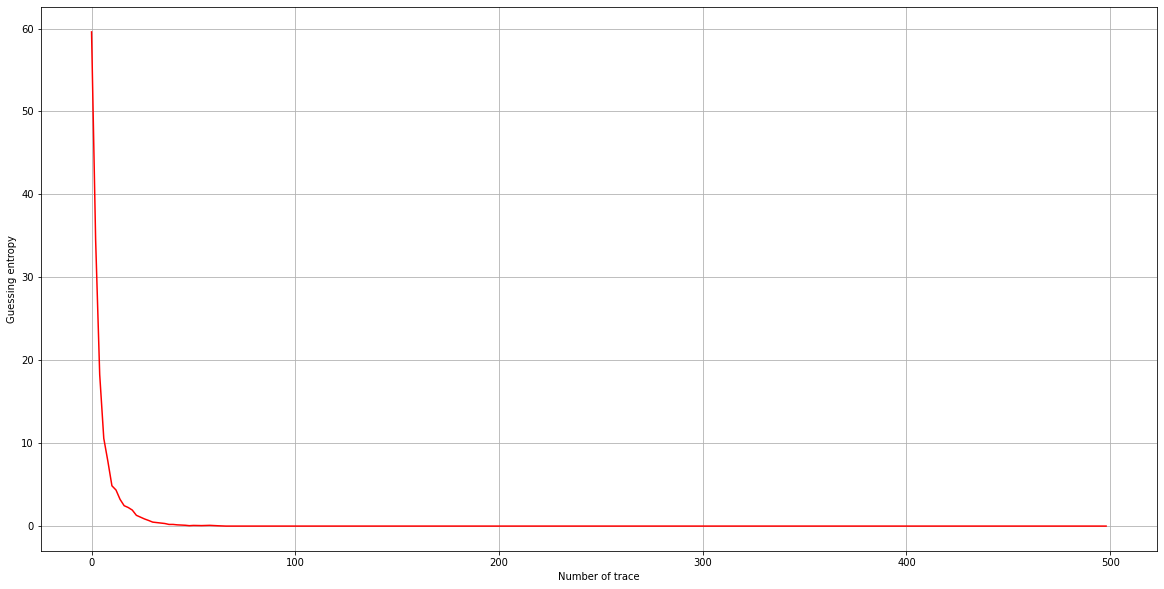

In [7]:
# create a network
model = Net(num_classes=class_num)
print('Construct model complete')
if cuda:
    model.cuda()
    
# load the pre-trained network 
checkpoint = torch.load('./models/ASCAD_variable_key.pth')
pretrained_dict = checkpoint['model_state_dict']
model_dict = pretrained_dict
model.load_state_dict(model_dict)

# evaluate the trained model
with torch.no_grad():
    print('Epoch:{}'.format(checkpoint['epoch']))
    test(model, model_flag='pretrained_source')

## Size of the network

In [8]:
model = Net(num_classes=class_num)
sum(p.numel() for p in model.parameters() if p.requires_grad)

41424

# Layer-wise correlation (LWC)

Construct model complete


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


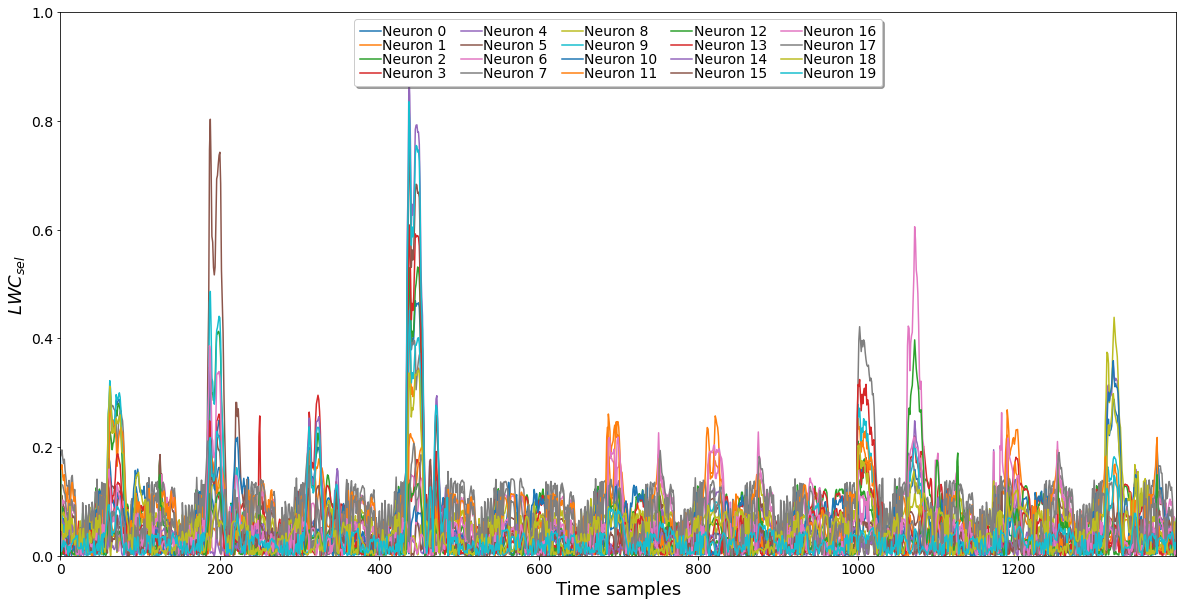

In [9]:
def get_layer_out(model):
    model.eval()
    iter_ = iter(train_loader_wo_shuffle)
    num_iter = len(train_loader_wo_shuffle)
    x0_output = np.zeros((train_num,1400),dtype=np.float64)
    x1_output = np.zeros((train_num,20),dtype=np.float64)
    bilinear_output = np.zeros((train_num,400),dtype=np.float64)
    x3_output = np.zeros((train_num,20),dtype=np.float64)
    final_output = np.zeros((train_num,class_num),dtype=np.float64)
    for i in range(1, num_iter+1):
        data, _ = iter_.next()
        if cuda:
            data= data.cuda()
        data = Variable(data)
        x0_o, x1_o, bilinear_x2_o, x3_o, final_o = model(data)
        x0_output[batch_size*(i-1):batch_size*i,:] = x0_o.cpu()
        x1_output[batch_size*(i-1):batch_size*i,:] = x1_o.cpu()
        bilinear_output[batch_size*(i-1):batch_size*i,:] = bilinear_x2_o.cpu()
        x3_output[batch_size*(i-1):batch_size*i,:] = x3_o.cpu()
        final_output[batch_size*(i-1):batch_size*i,:] = final_o.cpu()
    return x0_output, x1_output, bilinear_output,x3_output, final_output

### network for getting layer output
class Net_Layer_out(nn.Module):
    def __init__(self, num_classes=class_num):
        super(Net_Layer_out, self).__init__()
        # the encoder part
        self.features = nn.Sequential(
            nn.Conv1d(1, 2, kernel_size=1),
            nn.SELU(),
            nn.BatchNorm1d(2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Flatten()
        )
        # the fully-connected layer 1
        self.classifier_1 = nn.Sequential(
            nn.Linear(1400, 20),
            nn.SELU(),
        )
        # the fully-connected layer 2
        self.classifier_2 = nn.Sequential(
            nn.Linear(400, 20),
            nn.SELU()
        )
        # the output layer
        self.final_classifier = nn.Sequential(
            nn.Linear(20, num_classes)
        )
    
    # how the network runs
    def forward(self, input):
        x0 = self.features(input)
        x0 = x0.view(x0.size(0), -1)
        x1 = self.classifier_1(x0)
        bilinear_x2 = torch.bmm(x1.unsqueeze(2), x1.unsqueeze(1))
        bilinear_x2 = bilinear_x2.view(-1, x1.size(1) **2)
        x3 = self.classifier_2(bilinear_x2)
        output = self.final_classifier(x3)
        return x0, x1, bilinear_x2, x3, output
    
# create a network
model = Net_Layer_out(num_classes=class_num)
train_loader_wo_shuffle = load_testing(batch_size, kwargs_train)
print('Construct model complete')
if cuda:
    model.cuda()
    
# load the pre-trained network 
checkpoint = torch.load('./models/ASCAD_variable_key.pth')
pretrained_dict = checkpoint['model_state_dict']
model_dict = pretrained_dict
model.load_state_dict(model_dict)

# get the layer output
with torch.no_grad():
    x0_out,x1_out,bilinear_x2_out,x3_out, final_out = get_layer_out(model)

corr_layer0_vs_trs = Matrix_Cor(x1_out, X_train[0:train_num,:])
fig = plt.figure(figsize=(20,10))
fig1 = fig.add_subplot(1,1,1)
fig_labels = []
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 18,
}
fig1.set_xlabel("Time samples",font1)
fig1.set_ylabel(r"$LWC_{sel}$",font1)
for i in range(x1_out.shape[1]):
    fig1.plot(abs(corr_layer0_vs_trs[:,i]))
    fig_labels.append(r'Neuron %d' % (i))
fig1.legend(fig_labels, ncol=5, loc='upper center',
bbox_to_anchor=[0.5, 1.0],
columnspacing=1.0, labelspacing=0.0,
handletextpad=0.1, handlelength=1.5,
fancybox=True, shadow=True, fontsize=14)
fig1.set_ylim(0,1)
fig1.margins(0,0)
plt.yticks(size = 14)
plt.xticks(size = 14)
plt.show()

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


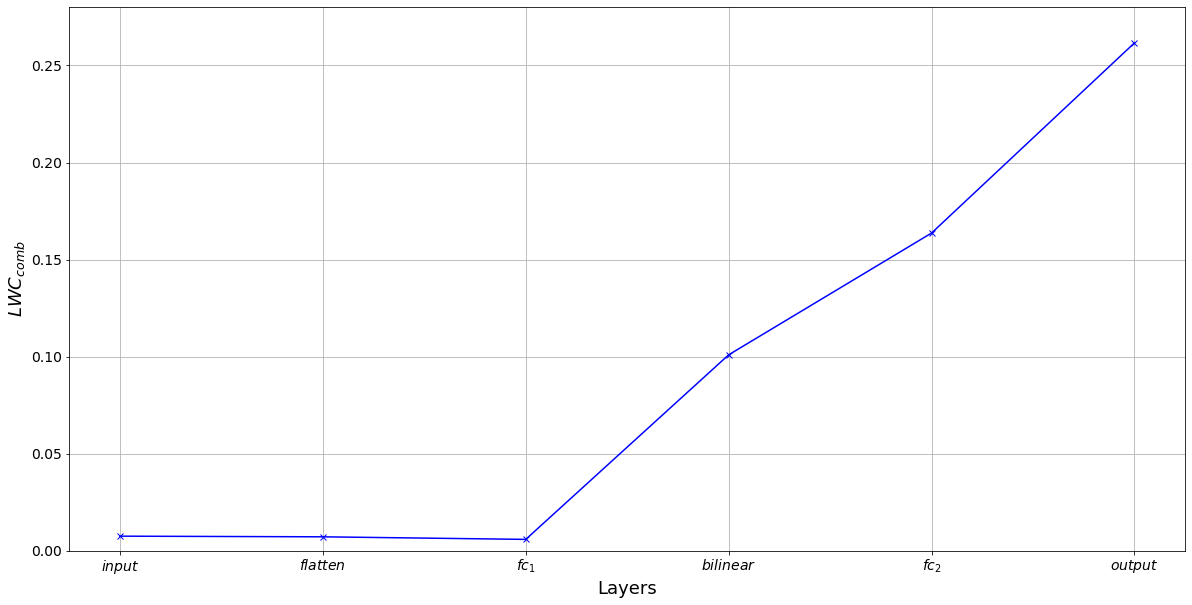

In [10]:
def LWC_comb(sbox_out, layer_output):
    median_mat = np.zeros((sbox_out.shape[0],1), dtype=np.float64, order='C')
    for i in range(0,sbox_out.shape[0]):
        temp = HW_byte[sbox_out[i]]
        median_mat[i,0] = temp
    corr_mat = Matrix_Cor(median_mat, layer_output)
    return corr_mat

layer_wise_corr = np.zeros((6), dtype = np.float64)
layer_wise_corr[0] = np.max(LWC_comb(Y_train[0:train_num], X_train[0:train_num,:]))
layer_wise_corr[1] = np.max(LWC_comb(Y_train[0:train_num], x0_out))
layer_wise_corr[2] = np.max(LWC_comb(Y_train[0:train_num], x1_out))
layer_wise_corr[3] = np.max(LWC_comb(Y_train[0:train_num], bilinear_x2_out))
layer_wise_corr[4] = np.max(LWC_comb(Y_train[0:train_num], x3_out))
layer_wise_corr[5] = np.max(LWC_comb(Y_train[0:train_num], final_out))

fig = plt.figure(figsize=(20,10))
fig3 = fig.add_subplot(1,1,1)
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 18,
}
ticks = [r'$input$',r'$flatten$',r'$fc_1$',r'$bilinear$',r'$fc_2$',r'$output$']
fig3.set_xlabel("Layers",font1)
fig3.set_ylabel(r"$LWC_{comb}$",font1)
labels = []
trace_num_max = 500
x = range(0, 6)
fig3.plot(x,layer_wise_corr, 'blue',marker='x')
plt.yticks(fontproperties = 'Times New Roman', size = 14)
plt.xticks(x, ticks, rotation=0, fontproperties = 'Times New Roman', size = 14)
fig3.set_ylim(0,0.28)
fig3.grid()
plt.show()